In [1]:
# import libraries
import os, zipfile
import numpy as np
import pandas as pd
import nltk
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

!pip install transformers
!pip install tensorflow_addons
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, BinaryAccuracy
from tensorflow.keras.utils import to_categorical

from transformers import TFBertModel,  BertConfig, BertTokenizerFast

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

     |████████████████████████████████| 3.1 MB 13.2 MB/s 
     |████████████████████████████████| 3.3 MB 28.5 MB/s 
     |████████████████████████████████| 61 kB 501 kB/s 
     |████████████████████████████████| 895 kB 37.7 MB/s 
     |████████████████████████████████| 596 kB 27.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.1 MB 10.5 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
url = 'https://raw.githubusercontent.com/ziwei-z/w266-project/main/data/en-annotated.tsv'
data = pd.read_csv(url, sep='\t', header=None, names=['sentence', 'label_raw'])

# make flag for each emotion
emotions = ['anger', 'anticipation', 'digust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
i = 1
for emo in emotions:
  data[emo] = data.label_raw.str.contains(str(i))*1
  i += 1

data['label'] = [y[2:].astype('float32') for (x, y) in enumerate(data.values)]
data.head()

train_X, test_X, train_Y, test_Y = train_test_split(data['sentence'], data['label'], test_size = 0.2, random_state=13)
train_X, dev_X, train_Y, dev_Y = train_test_split(train_X, train_Y, test_size = 0.25, random_state=13)

train_Y = np.concatenate([[train_Y.iloc[x] for x in list(range(len(train_Y)))]])
test_Y = np.concatenate([[test_Y.iloc[x] for x in list(range(len(test_Y)))]])
dev_Y = np.concatenate([[dev_Y.iloc[x] for x in list(range(len(dev_Y)))]])

In [4]:
data.head()

,sentence,label_raw,anger,anticipation,digust,fear,joy,sadness,surprise,trust,label
0,", ...",1,1,0,0,0,0,0,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
1,!,"1, 4, 7",1,0,0,1,0,0,1,0,"[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0]"
2,... And I don't think we need to discuss the T...,"8, 1",1,0,0,0,0,0,0,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"
3,* So get up out of your bed,1,1,0,0,0,0,0,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
4,A confession that you hired [PERSON] ... and a...,"1, 6",1,0,0,0,0,1,0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"


In [5]:
model_name = 'bert-base-uncased'

# Max length of tokens
max_length = 100

# Load transformers config and set output_hidden_states to False
config = BertConfig.from_pretrained(model_name)
config.output_hidden_states = False

# Load BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path = model_name, config = config)

# Load the Transformers BERT model
transformer_model = TFBertModel.from_pretrained(model_name, config = config)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
# Load the MainLayer
bert = transformer_model.layers[0]

# Build your model input
input_ids = Input(shape=(max_length,), name='input_ids', dtype='int32')
inputs = input_ids

# Load the Transformers BERT model as a layer in a Keras model
bert_model = bert(inputs)[1]
dropout = Dropout(config.hidden_dropout_prob, name='pooled_output')
pooled_output = dropout(bert_model, training=False)

# Then build your model output
outputs = Dense(units=8, kernel_initializer=TruncatedNormal(stddev=config.initializer_range), activation='sigmoid')(pooled_output)

# And combine it all in a model object
model = Model(inputs=input_ids, outputs=outputs, name='BERT_MultiLabel_MultiClass')

# Take a look at the model
model.summary()

Model: "BERT_MultiLabel_MultiClass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 100)]             0         
                                                                 
 bert (TFBertMainLayer)      TFBaseModelOutputWithPoo  109482240 
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             100, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                        

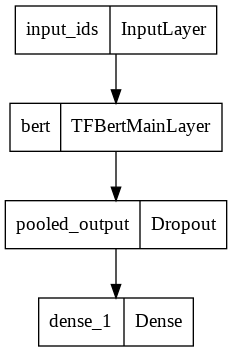

In [15]:
# look at the configuration
tf.keras.utils.plot_model(model)

In [16]:
# Set an optimizer
optimizer = Adam(
    learning_rate=5e-5,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits=True)
metric = BinaryAccuracy('accuracy')

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Tokenize the input (takes some time)
def tokenize(data):
    return tokenizer(
          text=data.tolist(),
          add_special_tokens=True,
          max_length=max_length,
          truncation=True,
          padding='max_length', 
          return_tensors='tf',
          return_token_type_ids = False,
          return_attention_mask = False,
          verbose = True)

x = tokenize(train_X)
x_dev = tokenize(dev_X)

# early stopping
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2)


In [17]:
# Fit the model
history = model.fit(
    x=x['input_ids'],
    y=train_Y,
    #validation_split = 0.2,
    validation_data=(x_dev['input_ids'], dev_Y),
    batch_size=64,
    epochs=3,
    callbacks = [es])

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


165/165 [==============================] - 430s 2s/step - loss: 0.3694 - accuracy: 0.8539 - val_loss: 0.3353 - val_accuracy: 0.8662
Epoch 2/3
165/165 [==============================] - 403s 2s/step - loss: 0.2893 - accuracy: 0.8873 - val_loss: 0.3267 - val_accuracy: 0.8667
Epoch 3/3
165/165 [==============================] - 405s 2s/step - loss: 0.2544 - accuracy: 0.9058 - val_loss: 0.3283 - val_accuracy: 0.8669


In [ ]:
#graph 
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# # summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper right')
# plt.show()

In [25]:
#save model
path = "/content/drive/MyDrive/W266 Project/saved models/bert_cls_5e-5_64_weights.h5"

model.save_weights(path)


In [ ]:
model.load_weights(path)

In [11]:
#evaluate

x_test = tokenize(test_X)

# # Run evaluation
# model_eval = model.evaluate(
#     x=x_test['input_ids'],
#     y=test_Y
# )

In [18]:
y_pred=model.predict(x_test['input_ids'])
y_pred_bool = (y_pred>0.5)*1  # because last layer was sigmoid

In [20]:
from sklearn.metrics import accuracy_score, hamming_loss

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

print('accuracy_score', accuracy_score(y_pred_bool, test_Y))
print('hamming loss  ', hamming_loss(y_pred_bool, test_Y))
print('hamming score ', hamming_score(test_Y, y_pred_bool))

accuracy_score 0.37992013690815746
hamming loss   0.1345907016543069
hamming score  0.4619271724662483


In [21]:
emotions = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'trust']
print(classification_report(test_Y, y_pred_bool, digits = 3, target_names = emotions))

              precision    recall  f1-score   support

       anger      0.593     0.463     0.520       775
anticipation      0.611     0.488     0.543       633
     disgust      0.613     0.300     0.403       460
        fear      0.589     0.402     0.478       500
         joy      0.681     0.610     0.643       592
     sadness      0.575     0.438     0.497       464
    surprise      0.578     0.345     0.432       505
       trust      0.611     0.434     0.508       564

   micro avg      0.610     0.443     0.513      4493
   macro avg      0.607     0.435     0.503      4493
weighted avg      0.608     0.443     0.509      4493
 samples avg      0.532     0.485     0.491      4493



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
for x in list(range(10,20)):
  print(accuracy_score([test_Y[x]], [y_pred_bool[x]]), test_Y[x], y_pred_bool[x], test_X.iloc[x])

1.0 [0. 0. 0. 1. 0. 0. 0. 0.] [0 0 0 1 0 0 0 0] You're sure we're not , uh , crowding you , eh ?
0.0 [0. 0. 0. 0. 0. 0. 1. 0.] [0 1 0 0 0 0 0 0] And what happens Tuesday ?
1.0 [0. 0. 0. 0. 0. 0. 1. 0.] [0 0 0 0 0 0 1 0] All that money , [PERSON] ?
0.0 [0. 0. 1. 0. 0. 0. 0. 0.] [0 0 0 0 0 0 0 0] We voted you best officer to be marooned on a desert island with .
1.0 [0. 0. 0. 1. 0. 0. 0. 0.] [0 0 0 1 0 0 0 0] I'll die if they send me to prison .
1.0 [0. 0. 0. 0. 0. 1. 0. 0.] [0 0 0 0 0 1 0 0] That I knew how miserable you were with him ?
0.0 [1. 0. 0. 0. 0. 0. 0. 0.] [0 0 0 0 0 1 0 0] It wasn't worth it .
1.0 [0. 0. 0. 0. 1. 0. 0. 0.] [0 0 0 0 1 0 0 0] Sure , everybody would prosper .
1.0 [0. 1. 0. 0. 0. 0. 0. 0.] [0 1 0 0 0 0 0 0] Hi , [LOCATION] . Can you put [PERSON] back on , please ?
0.0 [0. 0. 1. 0. 0. 0. 0. 0.] [1 0 0 0 0 0 0 0] How can you have the gall to compare the conflict here in [LOCATION] with a glass of cappuccino coffee ?


In [ ]:
#xxxxxxxxxxxxxxxxxxxx  not sure about below 

In [ ]:
con_mat = tfa.metrics.MultiLabelConfusionMatrix(y_true=test_Y, y_pred=y_pred_bool, labels=emotions, num_classes=3)
con_mat

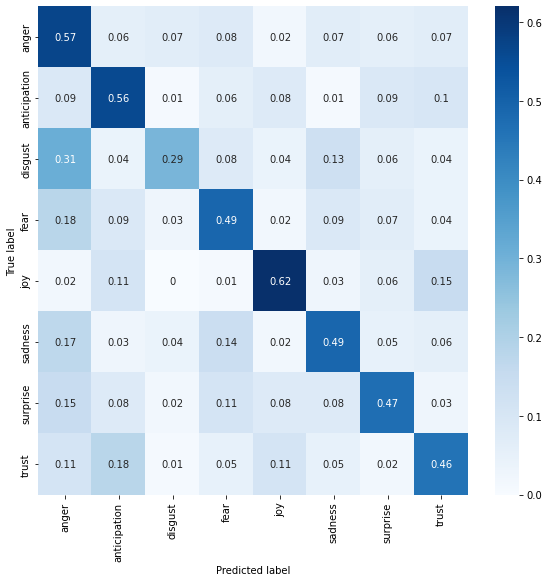

In [ ]:
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
classes = list(range(8))
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = emotions, 
                     columns = emotions)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()